# Lab 1 : Intro to TensorFlow and Music Generation with RNNs

# Part 2: Music Generation with RNNs

In this portion of the lab, we will play around with building a Recurrent Neural Network (RNN) for music generation. We will be using the MIDI music toolkit. Please run the following cell to confirm that you have the `midi` package, which allows us to use the MIDI music tools in Python.

In [ ]:
!pip install python-midi

## 2.1 Dependencies and Dataset
Here are the relevant packages and data we'll need for this lab. We decided to code the dataset cleaning and creation for you, which you can find in `create_dataset.py` and `midi_manipulation.py` if you're curious.

### 2.1.1 Dependencies

In [1]:
import os
os.chdir("C:/Users/Travel/Desktop/Sean/LearningTensorFlow/MIT Labs/lab1/")

import tensorflow as tf
from tensorflow.contrib import rnn
import numpy as np

import util.create_dataset
from util.util import print_progress
from util.create_dataset import create_dataset, get_batch
from util.midi_manipulation import noteStateMatrixToMidi

print(util.create_dataset.__file__)

C:\Users\Travel\Desktop\Sean\LearningTensorFlow\MIT Labs\lab1\util\create_dataset.py


### 2.1.2 The Dataset
The dataset for this lab will be taken from the `data/` folder within `lab1`. The dataset we have downloaded is a set of pop song snippets. If you double-click any of the MIDI files, you can open them with a music playing app such as GarageBand (Mac) or [MuseScore](https://musescore.org/en).

In [2]:
min_song_length  = 128
encoded_songs    = create_dataset(min_song_length)

88 songs processed
15 songs discarded


The dataset is a list of `np.array`s, one for each song. Each song should have the shape `(song_length, num_possible_notes)`, where `song_length >= min_song_length`. The individual feature vectors of the notes in the song are processed into a [one-hot](https://en.wikipedia.org/wiki/One-hot) encoding, meaning that they are binary vectors where one and only one entry is `1`. 

In [3]:
NUM_SONGS = len(encoded_songs)
print(str(NUM_SONGS) + " total songs to learn from")
print(encoded_songs[0].shape)

73 total songs to learn from
(257, 78)


## 2.2 The Recurrent Neural Network (RNN) Model

We will now define and train a RNN model on our music dataset, and then use that trained model to generate a new song. We will train our RNN using batches of song snippets from our dataset. 

This model will be based off a single LSTM cell, with a state vector used to maintain temporal dependencies between consecutive music notes. At each time step, we feed in a sequence of previous notes. The final output of the LSTM (i.e., of the last unit) is fed in to a single fully connected layer to output a probability distribution over the next note. In this way, we model the probability distribution 

$$ P(x_t\vert x_{t-L},\cdots,x_{t-1})$$ 

where $x_t$ is a one-hot encoding of the note played at timestep $t$ and $L$ is the length of a song snippet, as shown in the diagram below.

<img src="img/lab1ngram.png" alt="Drawing" style="width: 50em;"/>
 

### 2.2.1 Neural Network Parameters
Here, we define the relevant parameters for our model:

* `input_size` and `output_size` are defined to match the shape of the **encoded** inputs and outputs at each timestep. Recall that the encoded representation of each song  has shape `(song_length, num_possible_notes)`, with the notes played at each timestep encoded as a binary vector over all possible notes. The parameters `input_size` and `output_size` will reflect the length of this vector encoding -- the number of possible notes.
* `hidden_size` is the number of states in our LSTM and the size of the hidden layer we will have after our LSTM.
* The `learning_rate` of the model should be somewhere between `1e-4` and `0.1`. 
* `training_steps` is the number of batches we will use. 
* The `batch_size` is the number of song snippets we use per batch.
* To train the model, we will be choosing snippets of length `timesteps` from each song. This ensures that all song snippets have the same length and speeds up training. 

**We encourage you to experiment with different hyperparameters to see which performs the best!**

In [4]:
## Neural Network Parameters
input_size       = encoded_songs[0].shape[1]   # The number of possible MIDI Notes
output_size      = input_size                  # Same as input size
hidden_size      = 128                         # Number of neurons in hidden layer

learning_rate    = 0.001 # Learning rate of the model
training_steps   = 200  # Number of batches during training
batch_size       = 256    # Number of songs per batch
timesteps        = 64    # Length of song snippet -- this is what is fed into the model

assert timesteps < min_song_length

### 2.2.2 Model Initialization
Now, we will start building our model. Our model will need to make use of the TensorFlow graphs we talked about in Part 1 of this lab. Before we start building a graph, we need to define some placeholders and initialize weights.

We first define `tf.placeholder` variables (with `float` as the `dtype`) for the input and output tensors, `output_vec`.
* The input tensors will be used to hold the song snippet batches used during training. They will be 3-dimensional, with dimensions:
    1. The size of the batch (use `None` to let it handle any batch size)
    2. The number of time steps in a song snippet
    3. The number of possible MIDI notes
* The output tensors will be used to hold the **single note** that immediately follows a song snippet provided in the input tensor, for each song snippet in the training batch. So, they will be 2-dimensional, with dimensions: 
    1. The size of the batch (`None` as with the input tensors)
    2. The number of possible MIDI notes

Next, we have to initialize the weights and biases of the fully connected layer after the LSTM. The convention for defining such weights and biases is with a dictionary, so that you can name each layer. Since we only have one layer after the LSTM, we can just define the weights and biases with two individual `tf.Variable`s. We initialize by sampling from a Normal distribution using `tf.random_normal`.

In [5]:
input_placeholder_shape = [None, timesteps, input_size] #TODO
output_placeholder_shape = [None, output_size] #TODO

input_vec  = tf.placeholder("float", input_placeholder_shape)  
output_vec = tf.placeholder("float", output_placeholder_shape)  

# Define weights
weights = tf.Variable(tf.random_normal([hidden_size, output_size])) 

biases = tf.Variable(tf.random_normal([output_size])) # TODO define biases 

### 2.2.3 RNN Computation Graph
Now that we've defined the model parameters, placeholder variables for the input and output tensors, and initialized weights, it's time to build the TensorFlow computation graph itself! We can define a function `RNN(input_vec, weights, biases)`, which will take in the corresponding placeholders and variables, and return a graph. Remember that we have also imported the TensorFlow `rnn` module. The function [`rnn.BasicLTMCell`](https://www.tensorflow.org/api_docs/python/tf/contrib/rnn/BasicLSTMCell) will be useful. Go through the code below to define the RNN!

In [6]:
def RNN(input_vec, weights, biases):
    """
    @param input_vec: (tf.placeholder) The input vector's placeholder
    @param weights: (tf.Variable) The weights variable
    @param biases: (tf.Variable) The bias variable
    @return: The RNN graph that will take in a tensor list of shape (batch_size, timesteps, input_size)
    and output tensors of shape (batch_size, output_size)
    """
    # First, use tf.unstack() to unstack the timesteps into (batch_size, n_input). 
    # Since we are unstacking the timesteps axis, we want to pass in 1 as the 
    #  axis argument and timesteps as the length argument
    input_vec = tf.unstack(input_vec, timesteps, 1)

    '''TODO: Use TensorFlow's rnn module to define a BasicLSTMCell. 
    Think about the dimensionality of the output state -- how many hidden states will the LSTM cell have?''' 
    lstm_cell = rnn.BasicLSTMCell(hidden_size) # TODO 

    # Now, we want to get the outputs and states from the LSTM cell.
    # We rnn's static_rnn function, as described here: 
    #  https://www.tensorflow.org/api_docs/python/tf/nn/static_rnn
    outputs, states = rnn.static_rnn(lstm_cell, input_vec, dtype=tf.float32)
    
    # Next, let's compute the hidden layer's transformation of the final output of the LSTM.
    # We can think of this as the output of our RNN, or as the activations of the final layer. 
    # Recall that this is just a linear operation: xW + b, where W is the set of weights and b the biases.
    '''TODO: Use TensorFlow operations to compute the hidden layer transformation of the final output of the LSTM'''
    recurrent_net = tf.matmul(outputs[-1], weights) + biases # TODO 
    
    # Lastly, we want to predict the next note, so we can use this later to generate a song. 
    # To do this, we generate a probability distribution over the possible notes, 
    #  by computing the softmax of the transformed final output of the LSTM.
    '''TODO: Use the TensorFlow softmax function to output a probability distribution over possible notes.'''
    prediction = tf.nn.softmax(recurrent_net) # TODO
    
    # All that's left is to return recurrent_net (the RNN output) and prediction (the softmax output)
    return recurrent_net, prediction

### 2.2.4 Loss, Training, and Accuracy Operations
We still have to define a few more things for our network. Though we have defined the body of the computation graph, we need a loss operation, a training operation, and an accuracy function:
* Loss: We use the **mean** [softmax cross entropy loss](https://www.tensorflow.org/versions/master/api_docs/python/tf/nn/softmax_cross_entropy_with_logits_v2) to measure the probability error between the RNN's prediction of the next note and the true next note.  
* Training: Once we define the loss operation, we will use an optimizer to minimize the loss.
* Accuracy: We will measure accuracy by comparing the most likely next note, as predicted by our network, and the true next note. 
Now we can go ahead and define these remaining components!

In [7]:
logits, prediction = RNN(input_vec, weights, biases)

In [8]:
# LOSS OPERATION:
'''TODO: Use TensorFlow to define the loss operation as the mean softmax cross entropy loss. 
TensorFlow has built-in functions for you to use. '''
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
    logits=logits, labels=output_vec))  # TODO 

In [9]:
# TRAINING OPERATION:
'''TODO: Define an optimizer for the training operation. 
Remember we have already set the `learning_rate` parameter.'''
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) # TODO
train_op = optimizer.minimize(loss_op) 

In [10]:
# ACCURACY: We compute the accuracy in two steps.

# First, we need to determine the predicted next note and the true next note, across the training batch, 
#  and then determine whether our prediction was correct. 
# Recall that we defined the placeholder output_vec to contain the true next notes for each song snippet in the batch.
'''TODO: Write an expression to obtain the index for the most likely next note predicted by the RNN.'''
true_note = tf.argmax(output_vec,1)
pred_note = tf.argmax(prediction, 1) # TODO
correct_pred = tf.equal(pred_note, true_note)

# Next, we obtain a value for the accuracy. 
# We cast the values in correct_pred to floats, and use tf.reduce_mean
#  to figure out the fraction of these values that are 1's (1 = correct, 0 = incorrect)
accuracy_op = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [11]:
# INITIALIZER:
# Finally we create an initializer to initialize the variables we defined in Section 2.2.2
# We use TensorFlow's global_variables_initializer
init = tf.global_variables_initializer()

### 2.2.5 Training the RNN
We are finally ready to train our RNN model! We will use [`tf.InteractiveSession()`](https://www.tensorflow.org/api_docs/python/tf/InteractiveSession) to execute the graph and train the model. 

We need to do the following:
0. Launch the session
1. Initialize the variables
2. For each training step:
    * Get a training batch: 
        * `batch_x`: a batch of song snippets
        * `batch_y`: the next note for each song snippet in the batch
    * Run the training operation over the batch
    * If we are on a display step:
        * Compute the loss and accuracy and print these metrics

In [12]:
# 1) Launch the session
sess = tf.InteractiveSession()

# 2) Initialize the variables
sess.run(init)

# 3) Train!
display_step = 1 # how often to display progress
for step in range(training_steps):
    # GET BATCH
    # Add the line to get training data batch (see util.get_batch or whatever for args) FIX THIS !
    '''TODO: Fill in the function call to obtain a training data batch. 
    Hint: See the file util/create_dataset.py.'''
    batch_x, batch_y = get_batch(encoded_songs, batch_size, timesteps, input_size, output_size) # TODO
    
    # TRAINING: run the training operation with a feed_dict to fill in the placeholders
    '''TODO: Feed the training batch into the feed_dict.'''
    feed_dict = {
                    input_vec: batch_x, # TODO remove after colon
                    output_vec: batch_y # TODO remove after colon
                }
    sess.run(train_op, feed_dict=feed_dict)
    
    # DISPLAY METRICS
    if step % display_step == 0 or step == 1:
        # LOSS, ACCURACY: Compute the loss and accuracy by running both operations 
        loss, acc = sess.run([loss_op, accuracy_op], feed_dict=feed_dict)     
        suffix = "\nStep " + str(step) + ", Minibatch Loss= " + \
                 "{:.4f}".format(loss) + ", Training Accuracy= " + \
                 "{:.3f}".format(acc)

        print_progress(step, training_steps, barLength=50, suffix=suffix)

 |--------------------------------------------------| 0.0% 
 |--------------------------------------------------| 0.5% 
 |--------------------------------------------------| 1.0% 
 |=-------------------------------------------------| 1.5% 
 |=-------------------------------------------------| 2.0% 
 |=-------------------------------------------------| 2.5% 
 |==------------------------------------------------| 3.0% 
 |==------------------------------------------------| 3.5% 
 |==------------------------------------------------| 4.0% 
 |==------------------------------------------------| 4.5% 
 |==------------------------------------------------| 5.0% 
 |===-----------------------------------------------| 5.5% 
 |===-----------------------------------------------| 6.0% 
 |===-----------------------------------------------| 6.5% 
 |====----------------------------------------------| 7.0% 
 |====----------------------------------------------| 7.5% 
 |====----------------------------------

What is a good accuracy level for generating music? An accuracy of 100% means the model has memorized all the songs in the dataset, and can reproduce them at will. An accuracy of 0% means random noise. There must be a happy medium, where the generated music both sounds good and is original. In the words of Gary Marcus, "Music that is either purely predictable or completely unpredictable is generally considered unpleasant - tedious when it's too predictable, discordant when it's too unpredictable." Empirically we've found a good range for this to be `75%` to `90%`, but you should listen to generated output from the next step to see for yourself.

## 2.3 Music Generation
Now, we can use our trained RNN model to generate some music! When generating music, we'll have to feed the model some sort of seed to get it started (because it can't predict any notes without something to start with!). 

Once we have a generated seed, we can then iteratively predict each successive note using our trained RNN. More specifically, recall that our RNN outputs a probability distribution over possible successive notes. For inference, we iteratively sample from these distributions, and use our samples to encode a generated song. 

Then, all we have to do is write it to a file and listen!

There are 3 example generated files in the `/generated` folder. We trained a model using the following parameters to generate these examples: `hidden_size=256`, `learning_rate=0.001`, `training_steps=2000`, `batch_size=128`. Try to train a better sounding model using different parameters!

In [13]:
import matplotlib.pyplot as plt

saved generated song! seed ind: 41


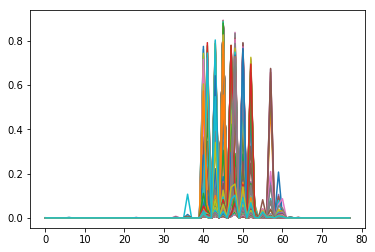

In [16]:
GEN_SEED_RANDOMLY = False # Use a random snippet as a seed for generating the new song.
if GEN_SEED_RANDOMLY:
    ind = np.random.randint(NUM_SONGS)
else:
    ind = 41 # "How Deep is Your Love" by Calvin Harris as a starting seed
    
gen_song = encoded_songs[ind][:timesteps].tolist() # TODO explore different (non-random) seed options
    
# generate music!
for i in range(500):
    seed = np.array([gen_song[-timesteps:]])
    # Use our RNN for prediction using our seed! 
    '''TODO: Write an expression to use the RNN to get the probability for the next note played based on the seed.
    Remember that we are now using the RNN for prediction, not training.'''
    predict_probs = sess.run(prediction, feed_dict = {input_vec:seed}) # TODO

    # Define output vector for our generated song by sampling from our predicted probability distribution
    played_notes = np.zeros(output_size)
    '''TODO: Sample from the predicted distribution to determine which note gets played next.
    You can use a function from the numpy.random library to do this.
    Hint 1: range(x) produces a list of all the numbers from 0 to x
    Hint 2: make sure predict_probs has the "shape" you expect. you may need to flatten it: predict_probs.flatten()'''
    #print(np.argmax(predict_probs[0]))
    plt.plot(predict_probs[0])
    sampled_note = np.random.choice(range(output_size), p=predict_probs[0]) # TODO
    #sampled_note = np.argmax(predict_probs[0])
    played_notes[sampled_note] = 1
    gen_song.append(played_notes)

noteStateMatrixToMidi(gen_song, name="generated/gen_song_0")
noteStateMatrixToMidi(encoded_songs[ind], name="generated/base_song_0")
print("saved generated song! seed ind: {}".format(ind))

## 2.4 What if We Didn't Train? 
To understand the impact of training and to see the progress of the network, let's see what the music sounds like with an untrained model.

To do this, set `training_steps = 0`, rerun the training cell above, and rerun the inference pipeline to generate a song with the untrained model.

## 2.5 Improving the Model

Congrats on making your first sequence model in tensorflow! It's a pretty big accomplishment, and hopefully you have some sweet tunes to show for it.

If you want to go further, here are some suggestions for improvements you can make to the model. *Please be advised that these are entirely optional and staff will only be helping with the lab portion of the assignment.*
1. **Use a different dataset.** If pop songs aren't your thing, or you want to try training on something else, all you need to do is replace the midi files located in your `/data` folder.
2. **Restrict the model output.** You may notice that even if you trained your model for a long time, the model still outputs really high/low notes from time to time. What's happening here is that although the probabilities of these notes appearing are very low, they are not 0 and therefore are still occassionally sampled by the model. To fix this, you could resample the probabilities to only be from notes close to the previous note, or keep sampling until you get a note close to the previous note. 
3. **Augment the dataset.** Maybe you don't think the dataset we've given you has enough songs, or that the genre of dataset you want to use is too small. An easy way to augment the dataset is by transposing the values in `batch_x` and `batch_y` such that they are randomly shifted up or down by the same amount, resulting in a different pitch. This helps you train a more robust model that can better learn how our perception of music is time dependent and space invariant. In other words, it depends more on the notes' relative position to each other rather than the pitch of the song as a whole. 
4. **Tune hyperparameters.** As we discussed in today's lectures, the hyperparameters used for training, such as the learning rate, number of hidden units, and the type of RNN cell used, can make a significant impact on the output. Try playing around with hyperparameters to see if you can improve the results. 
5. **Different optimizers.** In Lecture we learned that different optimizers can make a huge difference in converging to a nice solution during training. Try some different ones that Tensorflow has to offer and see what works best. 
5. **[advanced] Support polyphonic music.** If you look at the `make_one_hot_notes` function in `create_dataset.py`, you can see that indeed we chose to only take the melody from each song (assumed to be the highest played note at each time step). If you want to go beyond playing one note at a time, you can make changes to how the songs are encoded into matrices, along with how the model is structured to train and generate. A common task in deep learning with music is training a model on Bach chorales and getting it to understand the notion of chords in music. 

